# Time Series Forecasting

- **Goal: predict future demand of metro of the city of Chicago.**

- Data: monthly trip (after aggregation)

- Model: SARIMAX(order=(0,1,1), seasonal_order=(1,1,1,12))

- In sample prediction: Mean Square Error:343849383460.244, Mean Percentage Error: 3.2 %

- Out sample prediction


#### Import libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.metrics import mean_squared_error


In [2]:
# load data
data = pd.read_csv('CTA_Station_Monthly.csv')

In [3]:
data.head()

,station_id,stationame,month_beginning,avg_weekday_rides,avg_saturday_rides,avg_sunday-holiday_rides,monthtotal
0,40900,Howard,01/01/2001,"6,233.9","3,814.5","2,408.6","164,447"
1,41190,Jarvis,01/01/2001,"1,489.1","1,054",718,"40,567"
2,40100,Morse,01/01/2001,"4,412.5","3,064.5","2,087.8","119,772"
3,41300,Loyola,01/01/2001,"4,664.5","3,156","1,952.8","125,008"
4,40760,Granville,01/01/2001,"3,109.8","2,126","1,453.8","84,189"


In [4]:
data.describe()

,station_id
count,29460.000000
mean,40761.231840
std,445.675122
min,40010.000000
25%,40370.000000
50%,40750.000000
75%,41150.000000
max,41700.000000


In [5]:
data.dtypes

station_id                   int64
stationame                  object
month_beginning             object
avg_weekday_rides           object
avg_saturday_rides          object
avg_sunday-holiday_rides    object
monthtotal                  object
dtype: object

In [6]:
# Convert columns to float64
for column in ['avg_weekday_rides', 'avg_saturday_rides', 'avg_sunday-holiday_rides', 'monthtotal']:
    data[column] = data[column].str.replace(",", "").astype('float64')

# Convert column to datetime
data['month'] = pd.to_datetime(data['month_beginning'])

In [7]:
#Sanity check
data.dtypes

station_id                           int64
stationame                          object
month_beginning                     object
avg_weekday_rides                  float64
avg_saturday_rides                 float64
avg_sunday-holiday_rides           float64
monthtotal                         float64
month                       datetime64[ns]
dtype: object

#### Prepare data for forecasting
I am only interested at the total (sum) per month; therefore, I discard all the other information.


In [8]:
df1 = data.groupby(['month'])['month','monthtotal'].sum()

In [9]:
df1 = df1[:202] #only select the first 202 months because I did not need more for my use-case

#### Test-Train split

In [10]:
#Creating train and test set 
#df1.index = df1.month
#df1 = df1.resample('M').mean()

train=df1[0:190] #first 190 month as train
test=df1[190:] #the rest as test


In [11]:
#Sanity check
test

,monthtotal
month,
2016-11-01,16322767.0
2016-12-01,13999200.0
2017-01-01,14626737.0
2017-02-01,14142406.0
2017-03-01,16073109.0
2017-04-01,15169117.0
2017-05-01,16298485.0
2017-06-01,16737259.0
2017-07-01,15917931.0


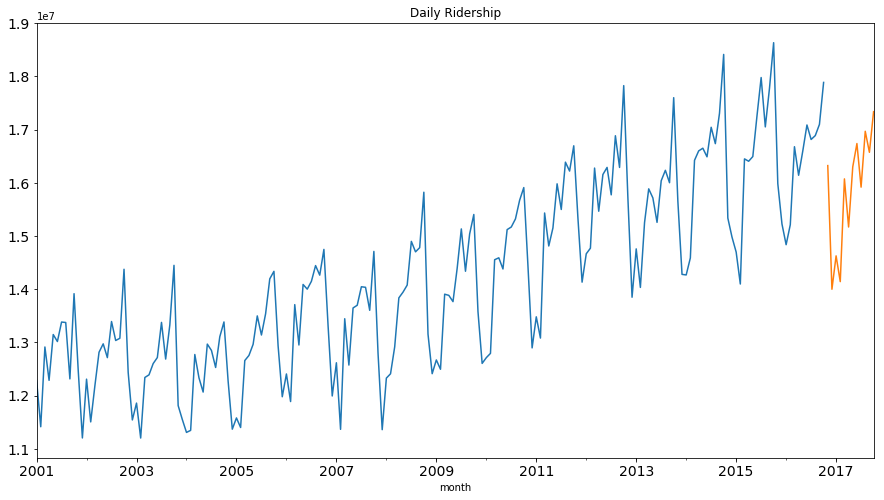

In [12]:
#Plotting data
train.monthtotal.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.monthtotal.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

**The monthly trips are highly seasonal with an increasing trend. Hence, a SARIMAX model seems to be a good idea**

#### Check for Stationarity

In [13]:
# Function for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Users\viret\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


C:\Users\viret\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
C:\Users\viret\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


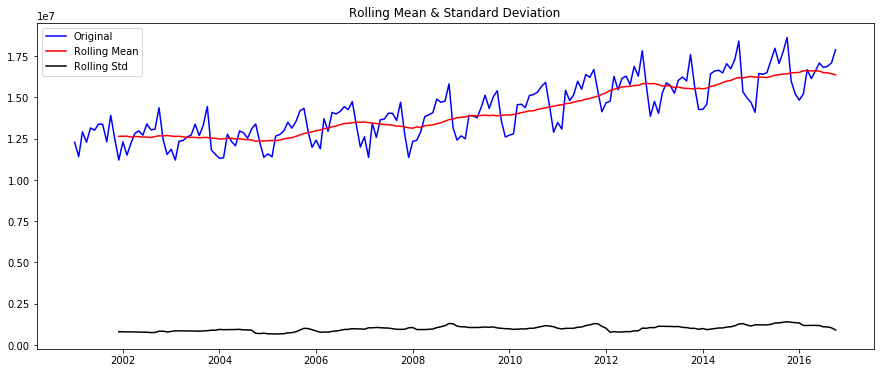

Results of Dickey-Fuller Test:
Test Statistic                  -0.940635
p-value                          0.774296
#Lags Used                      14.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64


In [14]:
test_stationarity(train.monthtotal)

**P-value is high that 0.05, therefore we reject the null hypotheses of the dickey-fuller test: the means are stationary – Also confirmed by the graph.**

#### ACF - PACF

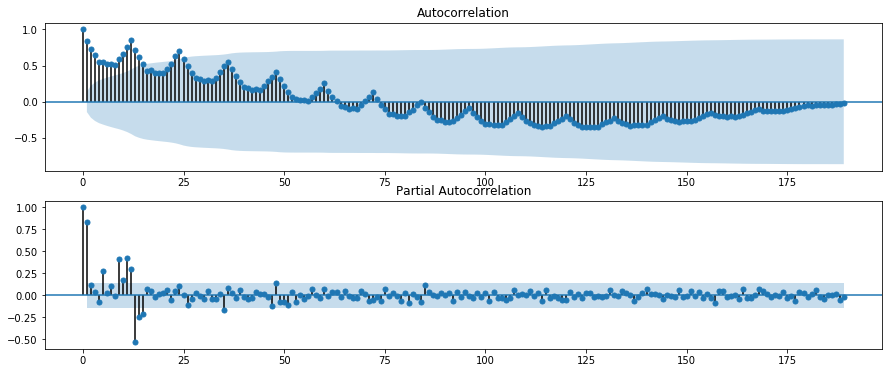

In [15]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure()
pyplot.subplot(211)
plot_acf(train.monthtotal, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(train.monthtotal, ax=pyplot.gca())
pyplot.show()

**The non-stationarity in the mean is also confirmed by the PACF which shows many lags out of bounces and the ACF have a clear decreasing trend, which indicated that there is some seasonal factor to be taken in consideration.**

### One Difference

**By adding one difference to the original data, it should result in converting the original data, which are not stationary to stationary in the mean.**

C:\Users\viret\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
C:\Users\viret\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


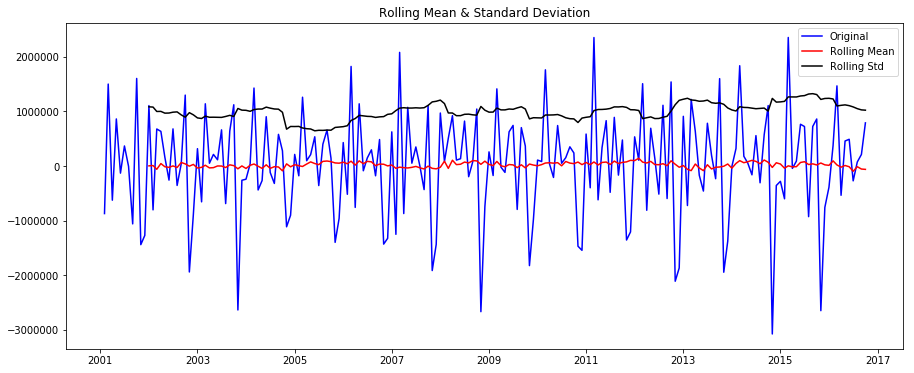

Results of Dickey-Fuller Test:
Test Statistic                  -3.263029
p-value                          0.016614
#Lags Used                      15.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64


In [16]:
#add on difference to the original data
one_dif = pd.DataFrame(index=train.index[1:])
one_dif['monthtotal'] = np.diff(train.monthtotal)

#stationary test
test_stationarity(one_dif.monthtotal)

**P-value is lower that 0.05, therefore we cannot reject the null hypotheses of the dickey-fuller test: the data are stationary in the mean**

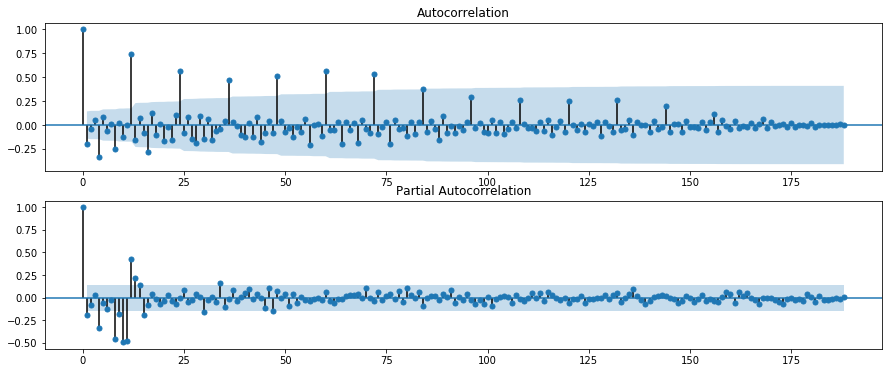

In [17]:
from matplotlib import pyplot
pyplot.figure()
pyplot.subplot(211)

plot_acf(one_dif.monthtotal, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(one_dif.monthtotal, ax=pyplot.gca())
pyplot.show()

**However, there is still a trend in the ACF, which indicated that seasonality has be considered – each twelfth lag (12,24,36…) are out of bounces; which make sense for monthly data, because the seasonality usually happen every year for a given month. **

#### Model: SARIMAX

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


order,seasonal_order,AIC = [],[],[]  #create lists
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            mod = SARIMAX(train.monthtotal,
                                            exog=None,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit(dispo= False)
        
            order.append(param),seasonal_order.append(param_seasonal),AIC.append(results.aic)
        except:
            continue  #ignore potential erros
           
data = pd.DataFrame({'order':order,'seasonal_order':seasonal_order,'AIC':AIC}) #load list to a Dataframe


In [19]:
data.sort_values('AIC',ascending=True).head(4)

,AIC,order,seasonal_order
34,5180.271370,"(1, 1, 0)","(1, 1, 1, 12)"
21,5182.618022,"(0, 1, 1)","(1, 1, 1, 12)"
42,5183.503582,"(1, 1, 1)","(1, 1, 1, 12)"
13,5192.979386,"(0, 1, 0)","(1, 1, 1, 12)"


                                 Statespace Model Results                                 
Dep. Variable:                         monthtotal   No. Observations:                  190
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2587.309
Date:                            Tue, 17 Jul 2018   AIC                           5182.618
Time:                                    15:07:42   BIC                           5195.606
Sample:                                01-01-2001   HQIC                          5187.879
                                     - 10-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1544      0.018     -8.538      0.000      -0.190      -0.119
ar.S.L12       0.6468      0.053   

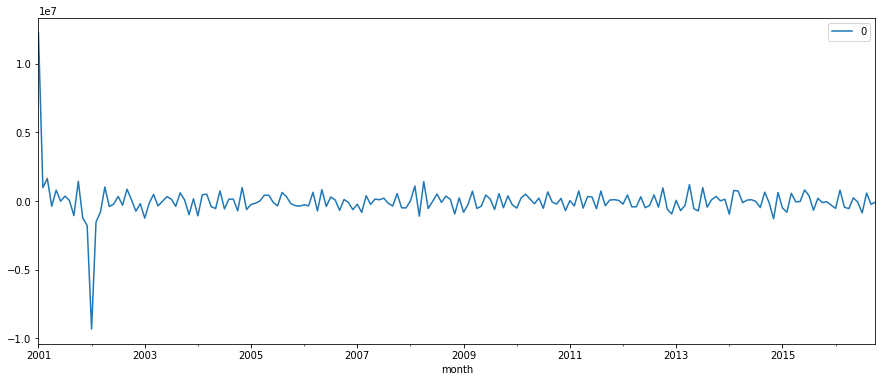

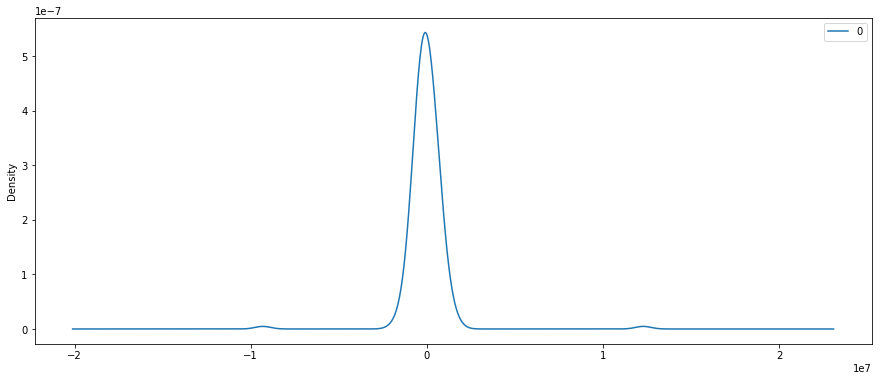

                  0
count  1.900000e+02
mean  -2.675424e+04
std    1.262790e+06
min   -9.313125e+06
25%   -4.429535e+05
50%   -5.813691e+04
75%    3.436914e+05
max    1.228690e+07


In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train.monthtotal,exog=None , order=(0,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)  
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

**I decided to go with a SARIMA (0,1,1),(1,1,1,12) instead of (0,1,1),(1,1,1,12) because the AR1 was not significative (p value > 0.05).**

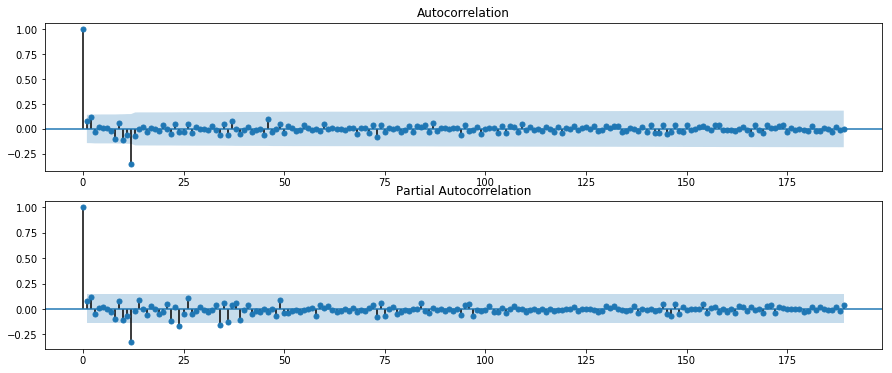

In [21]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(residuals, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(residuals, ax=pyplot.gca())
pyplot.show()

**Looking at the graph, the residuals are white noise (stationary in the mean) – with a small outlier in 2002 but it is minor, especially because it is far in the past compare to the last date of the dataset. In addition, the residuals are also gaussian white noise, because they are somehow normality distributed.**

#### In Sample Prediction

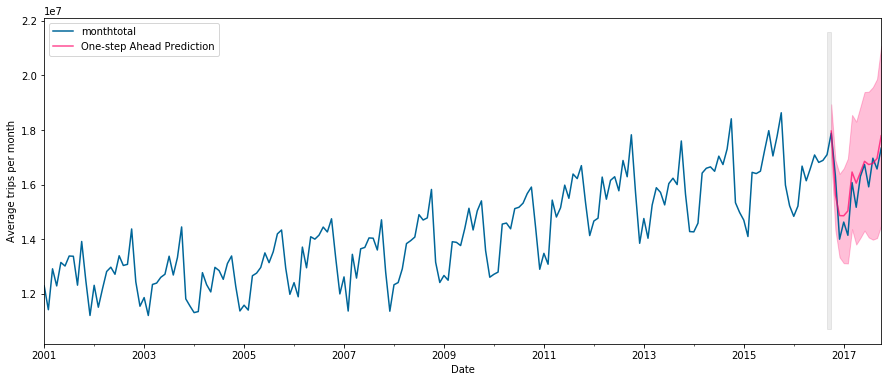

In [22]:
# in-sample-prediction and confidence bounds
pred = model_fit.get_prediction(start=pd.to_datetime('2016-10-01 00:00:00'), 
                          end=pd.to_datetime('2017-10-01 00:00:00'),
                          dynamic=True)
pred_ci = pred.conf_int()
 
# plot in-sample-prediction
ax = df1.plot(label='Observed',color='#006699');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='#ff0066');
 
# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
 
# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-09-30 00:00:00'), train.index[-1], alpha=.15, zorder=-1, color='grey');
ax.set_xlabel('Date')
ax.set_ylabel('Average trips per month')
plt.legend(loc='upper left')
plt.show()

predicted=16322767.000000, expected=15614263.545136, difference=-708503.454864
predicted=13999200.000000, expected=14864202.715538, difference=865002.715538
predicted=14626737.000000, expected=14857824.784570, difference=231087.784570
predicted=14142406.000000, expected=15035057.858100, difference=892651.858100
predicted=16073109.000000, expected=16460495.995569, difference=387386.995569
predicted=15169117.000000, expected=16053968.467705, difference=884851.467705
predicted=16298485.000000, expected=16444026.297376, difference=145541.297376
predicted=16737259.000000, expected=16853249.296615, difference=115990.296615
predicted=15917931.000000, expected=16734241.304203, difference=816310.304203
predicted=16967756.000000, expected=16777146.603710, difference=-190609.396290
predicted=16572350.000000, expected=16956486.866609, difference=384136.866609
predicted=17336213.000000, expected=17792101.631968, difference=455888.631968
Mean Square Error: 343849383460.244


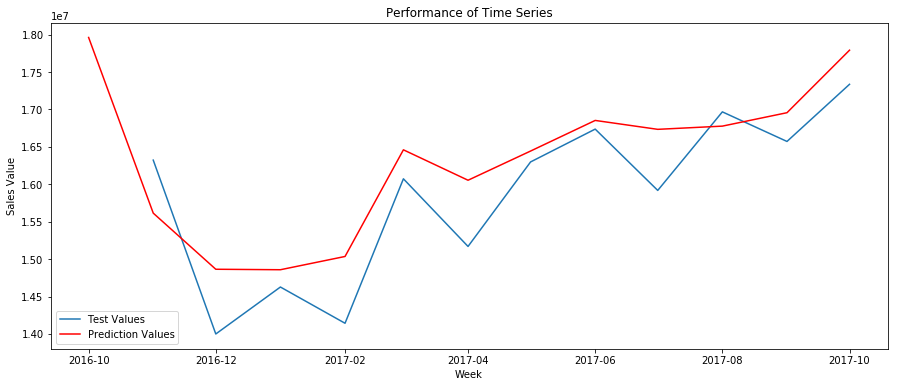

In [117]:
#load prediction in a DF
prediction = pd.DataFrame({'prediction':pred.predicted_mean})

#loop to have each month prediction
for i in range(0,len(test)):
    print('predicted=%f, expected=%f, difference=%f' % (test.iloc[i,0], prediction.iloc[1+i,0],-(test.iloc[i,0]-prediction.iloc[1+i,0])))

#get mean square error    
error = mean_squared_error(test, prediction.iloc[1:,0])
print('Mean Square Error: %.3f' % error)


#plot results
# plot
pyplot.plot(test)
pyplot.plot(prediction, color='red')
plt.title('Performance of Time Series')
plt.legend(['Test Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

**Check Mean Percentage Error**

In [118]:
mpe = sum(abs(test.iloc[:,0]-prediction.iloc[1:,0]))/sum(test.iloc[:,0])
print('Mean Percentage Error = %f' %(mpe.mean()*100))

Mean Percentage Error = 3.196179


**Mean percentage error is okay with 3.2% difference between the prediction and actual values.**

### long term forecast

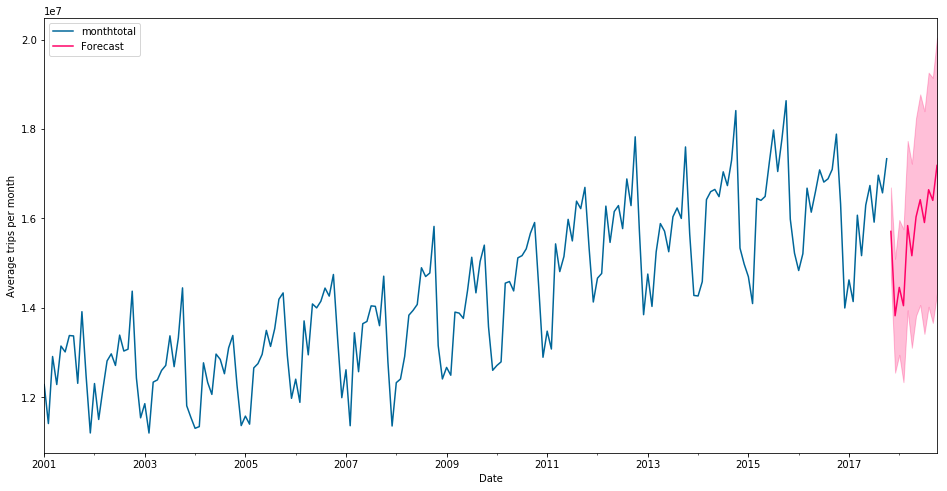

In [109]:
import statsmodels.api as sm
# build model and fit
res = sm.tsa.statespace.SARIMAX(df1,
                                 order=(0,1,1), seasonal_order=(1,1,1,12),
                                enforce_stationarity=True,
                                enforce_invertibility=True).fit()
 
# get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=12)
 
# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
 
# plot time series and long-term forecast
ax = df1.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Average trips per month');
plt.legend(loc='upper left')
plt.show()

In [110]:
train_pred = pred_uc.predicted_mean
train_ci =pred_uc.conf_int()

In [111]:
train_pred

2017-11-01    1.571114e+07
2017-12-01    1.382528e+07
2018-01-01    1.445928e+07
2018-02-01    1.405009e+07
2018-03-01    1.584173e+07
2018-04-01    1.516733e+07
2018-05-01    1.603381e+07
2018-06-01    1.642009e+07
2018-07-01    1.590916e+07
2018-08-01    1.664297e+07
2018-09-01    1.640505e+07
2018-10-01    1.718578e+07
Freq: MS, dtype: float64